In [20]:
%matplotlib ipympl
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
from impedance.visualization import plot_nyquist, plot_bode
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import pandas as pd
from scipy import stats

In [21]:
def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))
    
def give_chi_square(zexp,zmodel):
     chi_sqr=np.sum(np.abs((zexp-zmodel))**2)
     return chi_sqr
    
def give_chi_square_wt(zexp,zmodel):
     chi_sqr_wt=np.sum(np.abs((zexp-zmodel))**2/np.abs(zexp)**2)
     return chi_sqr_wt

def give_chi_square_by_N(zexp,zmodel):
     chi_sqr=np.sum(np.abs((zexp-zmodel))**2)
     return np.sqrt((chi_sqr)/len(zexp))

In [22]:
@element(num_params=4, units=["Ohm","Ohm", "F", ""],overwrite=True)
def TLMuni(p, f):
    omega = 2 * np.pi * np.array(f)
    R, Rion, Q, alpha = p[0], p[1], p[2], p[3]
    S=Rion*Q*(1j*omega)**alpha
    Z= R+Rion*np.sqrt(1/(S))*(1/(np.tanh(np.sqrt(S))))
    return Z

@element(num_params=4, units=["Ohm","Ohm", "F", ""],overwrite=True)
def TLMuniEC(p, f):
    omega = 2 * np.pi * np.array(f)
    R, Rion, tau, alpha = p[0], p[1], p[2], p[3]
    S=(1j*omega*tau)**alpha
    Z= R+Rion*np.sqrt(1/S)*(1/(np.tanh(np.sqrt(S))))
    return Z



In [23]:
exp_data=pd.read_excel("compare EC and pyhton on abhi data unit and mod.xlsx",sheet_name="circle data")
exp_data=exp_data.to_numpy()
z_exp_data=exp_data[:,1]+1j*exp_data[:,2]
freq_exp_data=exp_data[:,0]
#freq_exp_data

Chi2 2.9969673560994052
Chi2 by mod Z 2 2.9133858650104657e-06
Chi by sqrt(N) 0.17398964778502665
#########

parameters fit [1.00960710e+03 1.00420102e+02 1.03150260e-06 6.96816065e-01]
parameters SD [3.23643021e-02 3.97566102e-02 6.87005802e-09 5.24912270e-04]
Chi2 2.980356918220045
Chi2 by mod Z 2 2.8916690329347336e-06
Chi by sqrt(N) 0.17350681639508


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\impedance\models\circuits\circuits.py:145: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


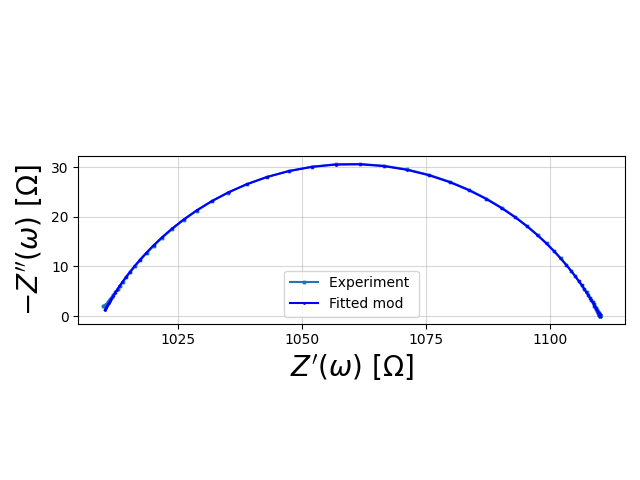

In [24]:
wt="mod"
c_circle=CustomCircuit(initial_guess=[1009.590323,100.4279958,0.000001026474557,0.6971274934],circuit="R_1-p(R_2,CPE_1)")
z_pred1=c_circle.predict(freq_exp_data)
print("Chi2",give_chi_square(z_exp_data,z_pred1))
print("Chi2 by mod Z 2",give_chi_square_wt(z_exp_data,z_pred1))
print("Chi by sqrt(N)",give_chi_square_by_N(z_exp_data,z_pred1))
print("#########\n")
c_fit_circle=c_circle.fit(freq_exp_data,z_exp_data,sigma=give_weights(z_exp_data,wt=wt),bounds=[(0,0,0,0),(np.inf,np.inf,np.inf,1)])


z_pred=c_fit_circle.predict(freq_exp_data)

fg, ax=plt.subplots()
plot_nyquist(z_exp_data,ax=ax,fmt="-X",ms=2,label=f"Experiment ")
plot_nyquist(z_pred,ax=ax,fmt="-o",color="blue",ms=1,label=f"Fitted {wt}")
ax.legend()
plt.tight_layout()
#print(give_chi_square_wt(z_exp_data,z_pred))
print("parameters fit",c_circle.parameters_)
print("parameters SD",c_circle.conf_)
print("Chi2",give_chi_square(z_exp_data,z_pred))
print("Chi2 by mod Z 2",give_chi_square_wt(z_exp_data,z_pred))
print("Chi by sqrt(N)",give_chi_square_by_N(z_exp_data,z_pred))

z_pred=np.transpose([np.real(z_pred),np.imag(z_pred)])
z_pred_df=pd.DataFrame(z_pred)
z_pred_df.to_excel(f"fitted z-data python on circle data.xlsx",sheet_name=f"{wt}")


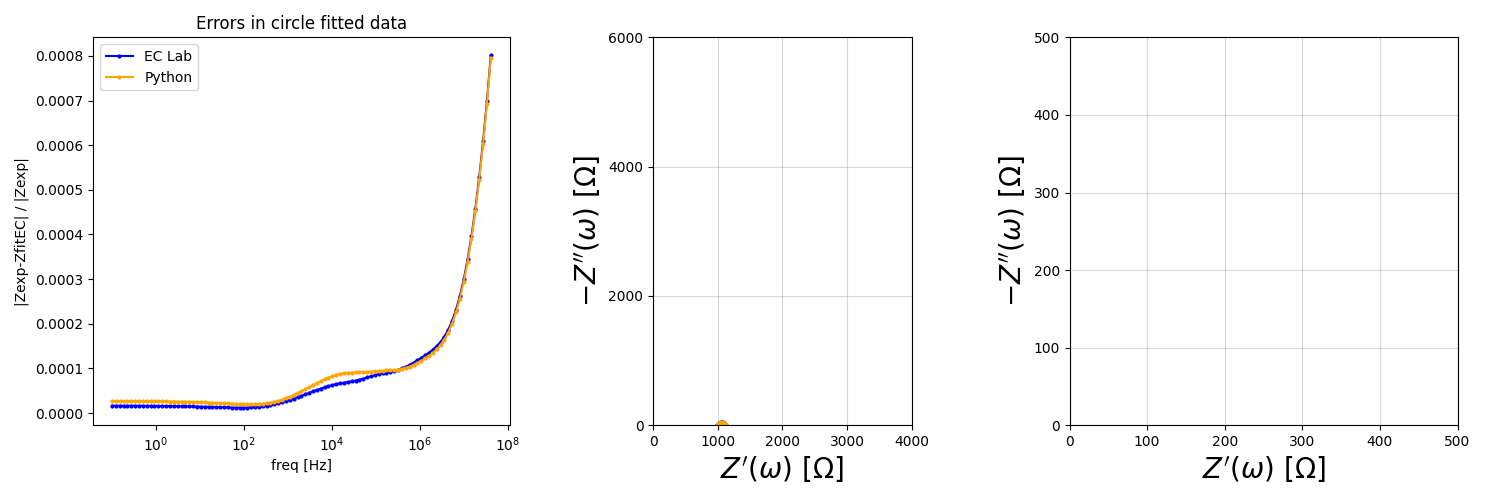

In [25]:
fitted_data=pd.read_excel("compare EC and pyhton on abhi data unit and mod.xlsx",sheet_name="circle data")
fitted_data=fitted_data.to_numpy()
#print(fitted_data)
z_EC_fitted_data=fitted_data[:,3]+1j*fitted_data[:,4]
z_python_fitted_data=fitted_data[:,5]+1j*fitted_data[:,6]
freq_fitted_data=fitted_data[:,0]
z_EC_error=np.abs(z_exp_data-z_EC_fitted_data)/np.abs(z_exp_data)
z_python_error=np.abs(z_exp_data-z_python_fitted_data)/np.abs(z_exp_data)

fig=plt.figure()
fig.set_size_inches(15,5)
axx=plt.subplot2grid((1,3),(0,0),rowspan=1,colspan=1)
axx.plot(freq_exp_data,z_EC_error,"-o",ms=2,label="EC Lab",color="blue")
axx.plot(freq_exp_data,z_python_error,"-o",ms=2,label="Python",color="orange")
axx.legend()
axx.set_title("Errors in circle fitted data")
axx.set_xscale("log")
axx.set_xlabel("freq [Hz]")
axx.set_ylabel("|Zexp-ZfitEC| / |Zexp|")

axx2=plt.subplot2grid((1,3),(0,1),rowspan=1,colspan=1)
plot_nyquist(z_exp_data,color="green",ax=axx2)
plot_nyquist(z_EC_fitted_data,color="blue",ax=axx2)
plot_nyquist(z_python_fitted_data,color="orange",ax=axx2)
axx2.set_xlim(0,4000)
axx2.set_ylim(0,6000)

axx3=plt.subplot2grid((1,3),(0,2),rowspan=1,colspan=1)
plot_nyquist(z_exp_data,color="green",ax=axx3)
plot_nyquist(z_EC_fitted_data,color="blue",ax=axx3)
plot_nyquist(z_python_fitted_data,color="orange",ax=axx3)
axx3.set_xlim(0,500)
axx3.set_ylim(0,500)


plt.tight_layout()
plt.show()